In [ ]:
%cd /content/drive/MyDrive/Research/Itihasa

/content/drive/MyDrive/Research/Itihasa


In [ ]:
import json

with open("Data/mahabharata_entities.json", "r", encoding="utf-8") as f:
    mahabharata_entities = json.load(f)

with open('Data/version_mapping.json', 'r', encoding='utf-8') as f:
    version_mapping = json.load(f)

with open("Data/full_text.json", "r", encoding="utf-8") as f:
    full_text = json.load(f)

with open("parsed_mahabharatam.json", "r", encoding="utf-8") as f:
    _mahabharata_parsed = json.load(f)

mahabharata_parsed = {_mahabharata_parsed[i]['id'].replace('M.', ''):_mahabharata_parsed[i]['words'] for i in range(len(_mahabharata_parsed))}

### Load Data

In [ ]:
parva_no = 2

def filter_k(k,i):
  k = k.replace('O', '0')
  if k.startswith(f'{i}.') and int(k.split('.')[1]) in list(range(11)):
    return True
  else:
    return False

vp_text = {k.replace('O', '0'): v for k, v in full_text.items() if filter_k(k,parva_no)}
# vp_parsed = {k: v for k, v in mahabharata_parsed.items() if filter_k(k,3)}
# vp_entities = {k: v for k, v in mahabharata_entities.items() if filter_k(k,parva_no)}


In [ ]:
len(vp_text)

319

### Initialize models

In [ ]:
!pip install sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util

multi_qa_mpnet = SentenceTransformer('multi-qa-mpnet-base-cos-v1')
multi_qa_distilbert = SentenceTransformer('multi-qa-distilbert-cos-v1')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/523 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Dataset

In [ ]:
import io
import pandas as pd
queries = pd.read_csv(io.StringIO('''
What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile
What is the relation between mental and physical ailments
What is the Surya Stuti recited by Yudhishthira
What does Dhritarashtra say to Vidura while banishing him
What advice does Vidura give Dhritarashtra after the departure of the Pandavas
What advice does Vyasa give Dhritarashtra on the plan of the kauravas
What is the story of Indra and Surabhi
What did Sage Maitreya tell Dhritarasthra
What did Sage Maitreya tell Duryodhana
'''), header=None)
queries = queries[0]
queries = list(queries)

_verses_gt = pd.read_csv(io.StringIO('''
2.1.12 - 2.1.27
2.2.17 - 2.2.23
2.3.22 - 2.3.47
2.4.17 - 2.4.20
2.4.6 - 2.4.16
2.8.1 - 2.8.10
2.9.5 - 2.9.16
2.10.11 - 2.10.17
2.10.19 - 2.10.24
'''), header=None)
_verses_gt = _verses_gt[0]
_verses_gt = list(_verses_gt)

In [ ]:
verses_gt = []
for r in _verses_gt:
    start, end = r.split('-')
    start, end = start.strip(), end.strip()

    s_parts = start.split('.')
    e_parts = end.split('.')

    prefix = '.'.join(s_parts[:-1])
    s_num, e_num = int(s_parts[-1]), int(e_parts[-1])

    verses_gt.append([f"{prefix}.{i}" for i in range(s_num, e_num + 1)])

### Retrieval

In [ ]:

def get_verses_batch(model, texts, target_texts, threshold=0.5):

    source_keys = list(texts.keys())
    source_embeddings = model.encode(source_keys, convert_to_tensor=True)
    results = {}

    for target_text in target_texts:
        print("Processing ", target_text)
        target_emb = model.encode(target_text, convert_to_tensor=True)
        similarities = util.cos_sim(target_emb, source_embeddings)[0].cpu().numpy()

        filtered_indices = [i for i, sim in enumerate(similarities) if sim >= threshold]
        filtered_texts = [source_keys[i] for i in filtered_indices]
        filtered_verses = [texts[i] for i in filtered_texts]
        filtered_sims = [similarities[i] for i in filtered_indices]

        sorted_triplets = sorted(
            zip(filtered_texts, filtered_verses, filtered_sims),
            key=lambda x: x[2],
            reverse=True
        )

        filtered_texts, filtered_verses, filtered_sims = zip(*sorted_triplets) if sorted_triplets else ([], [], [])
        results[target_text] = filtered_verses

    return results, similarities


In [ ]:
_texts = {} # Log - retrieval  6 min

keys = list(vp_text.keys())
for i in range(2, len(keys) - 2):  # skip first 2 and last 2
    k = keys[i]
    # Determine the 5-verse window (2 before, 2 after)
    start = max(0, i - 2)
    end = min(len(keys), i + 3)

    # Collect verse texts in this window
    window_text = " ".join(vp_text[keys[j]][1] for j in range(start, end))

    _texts[k] = window_text

texts = {v:k for k, v in _texts.items()}

In [ ]:
texts

{'Having saluted the Supreme Deity (Narayana) and the highest of all male beings (Nara) and also the Goddess of Learning (Sarasvati), Let us cry "success!" Janamejaya said : O best of Brahmanas, having been deceitfully defeated at dice by the sons of Dhritarashtra with their counsellors and having been provoked by the wicked-minded ones (the Kuru princes), who thus brought about a fearful hostility by addressing them in cruel words, what did the Kurus, my grandsires do? How did the sons of Pritha (the Pandavas), equal to Shakra (Indra) in effulgence, thus suddenly robbed of their affluence and overwhelmed with misery, pass their days in the forest? Who are the men that followed them, (the Pandavas) that were plunged in great affliction. What was their conduct, what was their food and where did those illustrious ones live? O great Rishi, O best of the Brahmanas, how did the twelve years of those heroes, those slayers of foes, pass away in the forest?': '2.1.3',
 'Janamejaya said : O bes

In [ ]:
texts = {v[1]:k for k, v in vp_text.items()}

In [ ]:
retrievals_1, similarities = get_verses_batch(multi_qa_mpnet, texts, queries)

Processing  What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile
Processing  What is the relation between mental and physical ailments
Processing  What is the Surya Stuti recited by Yudhishthira
Processing  What does Dhritarashtra say to Vidura while banishing him
Processing  What advice does Vidura give Dhritarashtra after the departure of the Pandavas
Processing  What advice does Vyasa give Dhritarashtra on the plan of the kauravas
Processing  What is the story of Indra and Surabhi
Processing  What did Sage Maitreya tell Dhritarasthra
Processing  What did Sage Maitreya tell Duryodhana


In [ ]:
retrievals_2 = get_verses_batch(multi_qa_distilbert, texts, queries)

Processing  What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile
Processing  What is the relation between mental and physical ailments
Processing  What is the Surya Stuti recited by Yudhishthira
Processing  What does Dhritarashtra say to Vidura while banishing him
Processing  What advice does Vidura give Dhritarashtra after the departure of the Pandavas
Processing  What advice does Vyasa give Dhritarashtra on the plan of the kauravas
Processing  What is the story of Indra and Surabhi
Processing  What did Sage Maitreya tell Dhritarasthra
Processing  What did Sage Maitreya tell Duryodhana


In [ ]:
for query, retrieval in retrievals_1.items():
  print(query, ":", retrieval)


What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile : ('2.1.10', '2.7.11', '2.7.12', '2.7.7', '2.7.15', '2.1.9', '2.1.34', '2.7.6', '2.7.8', '2.7.14', '2.1.6', '2.1.14', '2.1.13', '2.1.35', '2.8.1', '2.7.13', '2.7.5', '2.7.23', '2.1.36', '2.10.20', '2.1.16', '2.10.19', '2.1.11', '2.7.16', '2.5.11', '2.1.17', '2.1.33', '2.7.21', '2.7.9', '2.4.2', '2.7.3', '2.7.10', '2.8.4', '2.6.15', '2.1.38', '2.7.4', '2.7.17', '2.1.5', '2.8.2', '2.1.37', '2.7.20', '2.4.19', '2.2.3', '2.8.3', '2.1.19', '2.1.8', '2.7.18')
What is the relation between mental and physical ailments : ('2.2.21', '2.2.19', '2.2.20', '2.2.22', '2.2.17')
What is the Surya Stuti recited by Yudhishthira : ('2.3.23', '2.3.56', '2.3.18', '2.1.30')
What does Dhritarashtra say to Vidura while banishing him : ('2.6.18', '2.6.16', '2.6.6', '2.6.3', '2.6.15', '2.6.14', '2.6.17', '2.6.5', '2.6.2', '2.6.4', '2.5.13', '2.6.19', '2.4.19', '2.5.1', '2.7.1', '2.5.14', '2.6.13', '2.5.11', '2.5.17',

In [ ]:
for i, (v_ext, v_gt) in enumerate(zip(retrievals_1.values(), verses_gt)):
  tp = len(set(v_ext) & set(v_gt))
  total = len(v_gt)

  fp = len(set(v_ext) - set(v_gt))
  total_ext = len(v_ext)

  common = set(v_ext) & set(v_gt)
  if total_ext == 0:
    completeness = 0
    purity = 0
  else:
    completeness = tp/total
    purity = 1 - fp/total_ext
  print(f"Q.{i+1} | {common} | {v_gt[0]} - {v_gt[-1]} | {completeness} | {purity} ")

Q.1 | {'2.1.16', '2.1.17', '2.1.14', '2.1.19', '2.1.13'} | 2.1.12 - 2.1.27 | 0.3125 | 0.1063829787234043 
Q.2 | {'2.2.20', '2.2.22', '2.2.19', '2.2.17', '2.2.21'} | 2.2.17 - 2.2.23 | 0.7142857142857143 | 1.0 
Q.3 | {'2.3.23'} | 2.3.22 - 2.3.47 | 0.038461538461538464 | 0.25 
Q.4 | {'2.4.19', '2.4.20'} | 2.4.17 - 2.4.20 | 0.5 | 0.0444444444444444 
Q.5 | {'2.4.15', '2.4.16', '2.4.6'} | 2.4.6 - 2.4.16 | 0.2727272727272727 | 0.029126213592232997 
Q.6 | {'2.8.3', '2.8.1'} | 2.8.1 - 2.8.10 | 0.2 | 0.06666666666666665 
Q.7 | {'2.9.14', '2.9.10', '2.9.6', '2.9.13', '2.9.5', '2.9.11', '2.9.7', '2.9.8'} | 2.9.5 - 2.9.16 | 0.6666666666666666 | 1.0 
Q.8 | {'2.10.13', '2.10.11'} | 2.10.11 - 2.10.17 | 0.2857142857142857 | 0.09523809523809523 
Q.9 | {'2.10.20', '2.10.21', '2.10.19'} | 2.10.19 - 2.10.24 | 0.5 | 0.1875 


In [ ]:
for i, (v_ext, v_gt) in enumerate(zip(retrievals_2.values(), verses_gt)):
  tp = len(set(v_ext) & set(v_gt))
  total = len(v_gt)

  fp = len(set(v_ext) - set(v_gt))
  total_ext = len(v_ext)

  common = set(v_ext) & set(v_gt)

  if total_ext == 0:
    completeness = 0
    purity = 0
  else:
    completeness = tp/total
    purity = 1 - fp/total_ext
  print(f"Q.{i+1} | {common} | {v_gt[0]} - {v_gt[-1]} | {purity} | {completeness}")

NameError: name 'retrievals_2' is not defined

### Group visualizations

In [ ]:
!pip install indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
from indic_transliteration import sanscript

speakers = {}
curr_speaker = ""
for verse_id, verse in vp_text.items():
    words = verse[0].split( )
    if words[1] in ["उवाच", "ऊचुः"]:
        curr_speaker = words[0]
        curr_speaker_iast = sanscript.transliterate(
            curr_speaker, sanscript.DEVANAGARI, sanscript.IAST
        )
        speakers[verse_id] = curr_speaker_iast
    else:
        curr_speaker_iast = sanscript.transliterate(
            curr_speaker, sanscript.DEVANAGARI, sanscript.IAST
        )
        speakers[verse_id] = curr_speaker_iast


In [ ]:
speakers

{'2.1.1': '',
 '2.1.2': 'janamejaya',
 '2.1.3': 'janamejaya',
 '2.1.4': 'janamejaya',
 '2.1.5': 'janamejaya',
 '2.1.6': 'janamejaya',
 '2.1.7': 'janamejaya',
 '2.1.8': 'vaiśampāyana',
 '2.1.9': 'vaiśampāyana',
 '2.1.10': 'vaiśampāyana',
 '2.1.11': 'vaiśampāyana',
 '2.1.12': 'paurā',
 '2.1.13': 'paurā',
 '2.1.14': 'paurā',
 '2.1.15': 'paurā',
 '2.1.16': 'paurā',
 '2.1.17': 'vaiśampāyana',
 '2.1.18': 'vaiśampāyana',
 '2.1.19': 'vaiśampāyana',
 '2.1.20': 'vaiśampāyana',
 '2.1.21': 'vaiśampāyana',
 '2.1.22': 'vaiśampāyana',
 '2.1.23': 'vaiśampāyana',
 '2.1.24': 'vaiśampāyana',
 '2.1.25': 'vaiśampāyana',
 '2.1.26': 'vaiśampāyana',
 '2.1.27': 'vaiśampāyana',
 '2.1.28': 'yudhiṣṭhira',
 '2.1.29': 'yudhiṣṭhira',
 '2.1.30': 'yudhiṣṭhira',
 '2.1.31': 'yudhiṣṭhira',
 '2.1.32': 'yudhiṣṭhira',
 '2.1.33': 'yudhiṣṭhira',
 '2.1.34': 'vaiśampāyana',
 '2.1.35': 'vaiśampāyana',
 '2.1.36': 'vaiśampāyana',
 '2.1.37': 'vaiśampāyana',
 '2.1.38': 'vaiśampāyana',
 '2.1.39': 'vaiśampāyana',
 '2.1.40': 'vaiśampāy

In [ ]:
import numpy as np
import pandas as pd
from itertools import groupby

class SpeakerContinuityAnalyzer:
    def __init__(self, speakers_dict, alpha=0.2):
        """
        Initialize the analyzer.

        Parameters
        ----------
        speakers_dict : dict
            Mapping of verse_id → speaker (e.g., {'2.9.1': 'A', '2.9.2': 'B', ...})
        alpha : float, optional
            Decay factor controlling how fast continuity decreases with distance.
        """
        self.speakers_dict = speakers_dict
        self.alpha = alpha

    # ---------------------------------------------------------
    # 1. Filter verses belonging to the target verse's chapter
    # ---------------------------------------------------------
    def filter_chapter(self, target_verse):
        """
        Extract all verses from the same chapter as `target_verse`.

        Returns
        -------
        pd.DataFrame with columns ['verse_id', 'chapter', 'verse', 'speaker']
        """
        target_prefix = ".".join(target_verse.split(".")[:2])

        filtered = {
            k: v for k, v in self.speakers_dict.items()
            if k.startswith(target_prefix + ".")
        }

        rows = []
        for k, speaker in filtered.items():
            _, chapter, verse_num = k.split(".")
            rows.append({
                "verse_id": k,
                "chapter": target_prefix,
                "verse": int(verse_num),
                "speaker": speaker
            })

        df = pd.DataFrame(rows).sort_values("verse").reset_index(drop=True)
        return df

    # ---------------------------------------------------------
    # 2. Compute speaker continuity scores
    # ---------------------------------------------------------
    def compute_continuity_scores(self, df, target_verse_num):
        """
        Compute continuity scores for all verses in the same chapter.

        Parameters
        ----------
        df : pd.DataFrame
            Columns ['verse', 'speaker']
        target_verse_num : int
            Verse number serving as the reference point.
        """
        segments = []
        for spk, group in groupby(df.itertuples(index=False), key=lambda x: x.speaker):
            verses = [g.verse for g in group]
            segments.append({
                'speaker': spk,
                'start': verses[0],
                'end': verses[-1],
                'length': len(verses)
            })

        target_seg_idx = None
        for i, seg in enumerate(segments):
            if seg['start'] <= target_verse_num <= seg['end']:
                target_seg_idx = i
                break

        if target_seg_idx is None:
            raise ValueError(f"Target verse {target_verse_num} not found in the data.")

        target_seg = segments[target_seg_idx]
        target_speaker = target_seg['speaker']

        # Initialize scores
        df = df.copy()
        df['score'] = 0.0

        for j, seg in enumerate(segments):
          verse_mask = (df['verse'] >= seg['start']) & (df['verse'] <= seg['end'])

          if j == target_seg_idx:
              df.loc[verse_mask, 'score'] = 1.0
              continue

          if abs(j - target_seg_idx) == 1:
              _cont_score = target_seg['length'] / (target_seg['length'] + seg['length'])
              df.loc[verse_mask, 'score'] = _cont_score
              # continue  # we don’t continue yet — might also be same-speaker

          if seg['speaker'] == target_speaker:
              if j > target_seg_idx:
                  gap = seg['start'] - target_seg['end'] - 1
              else:
                  gap = target_seg['start'] - seg['end'] - 1
              gap = max(gap, 0)
              cont_score = np.exp(-self.alpha * gap)
              df.loc[verse_mask, 'score'] = cont_score


        return df

    # ---------------------------------------------------------
    # 3. Fill sandwiched scores
    # ---------------------------------------------------------
    def fill_sandwiched_scores(self, df, score_col="score"):
        """
        Smooth scores by averaging between non-zero neighbors.
        """
        scores = df[score_col].to_numpy(dtype=float)
        nz_indices = np.where(scores != 0)[0]

        for i in range(len(nz_indices) - 1):
            left, right = nz_indices[i], nz_indices[i + 1]
            left_val, right_val = scores[left], scores[right]
            if right - left > 1:
                avg_val = (left_val + right_val) / 2
                scores[left + 1:right] = avg_val

        df[score_col] = scores
        return df

    # ---------------------------------------------------------
    # 4. Complete pipeline
    # ---------------------------------------------------------
    def analyze(self, target_verse):
        """
        Complete pipeline:
        1. Filter by chapter
        2. Compute continuity scores
        3. Fill intermediate scores

        Parameters
        ----------
        target_verse : str
            e.g., '2.9.6'

        Returns
        -------
        pd.DataFrame
        """
        chapter_df = self.filter_chapter(target_verse)
        verse_num = int(target_verse.split(".")[-1])

        scored_df = self.compute_continuity_scores(chapter_df[['verse', 'speaker']], verse_num)
        final_df = self.fill_sandwiched_scores(scored_df)
        return final_df


In [ ]:
analyzer = SpeakerContinuityAnalyzer(speakers, alpha=0.2)
result_df = analyzer.analyze("2.1.15")

print(result_df)


    verse       speaker     score
0       1                0.000000
1       2    janamejaya  0.000000
2       3    janamejaya  0.000000
3       4    janamejaya  0.000000
4       5    janamejaya  0.000000
5       6    janamejaya  0.000000
6       7    janamejaya  0.000000
7       8  vaiśampāyana  0.555556
8       9  vaiśampāyana  0.555556
9      10  vaiśampāyana  0.555556
10     11  vaiśampāyana  0.555556
11     12         paurā  1.000000
12     13         paurā  1.000000
13     14         paurā  1.000000
14     15         paurā  1.000000
15     16         paurā  1.000000
16     17  vaiśampāyana  0.312500
17     18  vaiśampāyana  0.312500
18     19  vaiśampāyana  0.312500
19     20  vaiśampāyana  0.312500
20     21  vaiśampāyana  0.312500
21     22  vaiśampāyana  0.312500
22     23  vaiśampāyana  0.312500
23     24  vaiśampāyana  0.312500
24     25  vaiśampāyana  0.312500
25     26  vaiśampāyana  0.312500
26     27  vaiśampāyana  0.312500
27     28   yudhiṣṭhira  0.000000
28     29   yu

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


class SemanticContinuityAnalyzer:
    """
    Compute semantic continuity of verses based on contextual similarity.
    """

    def __init__(self, texts, chapter_id, model_name="all-MiniLM-L6-v2"):
        """
        Parameters
        ----------
        verse_texts : dict
            Mapping { "2.3.1": "text...", "2.3.2": "text...", ... }
        model_name : str
            SentenceTransformer model to use for embeddings.
        """
        self.verse_texts = {k: v[1] for k, v in texts.items() if k.startswith(f"2.{chapter_id}.")}
        self.model = SentenceTransformer(model_name)

    # -------------------------------------------------------
    # 1️⃣ Compute window-based similarities
    # -------------------------------------------------------
    def compute_window_similarities(self, target_verse, window=2, group_size=5):
        """
        Compute semantic similarity between the target verse window (±window)
        and every group of `group_size` consecutive verses.

        Returns
        -------
        pd.DataFrame : ['group_start', 'group_end', 'similarity']
        """
        keys = list(self.verse_texts.keys())
        if target_verse not in keys:
            raise ValueError(f"Target verse {target_verse} not found in dataset.")

        idx = keys.index(target_verse)

        # ---- target window ----
        start = max(0, idx - window)
        end = min(len(keys), idx + window + 1)
        target_chunk_texts = [self.verse_texts[k] for k in keys[start:end]]

        target_vec = self.model.encode(target_chunk_texts, convert_to_numpy=True).mean(axis=0, keepdims=True)

        # ---- compare with all sliding groups ----
        results = []
        for i in range(len(keys) - group_size + 1):
            group_keys = keys[i:i + group_size]
            group_texts = [self.verse_texts[k] for k in group_keys]

            group_vec = self.model.encode(group_texts, convert_to_numpy=True).mean(axis=0, keepdims=True)
            sim = cosine_similarity(target_vec, group_vec)[0][0]

            results.append({
                "group_start": group_keys[0],
                "group_end": group_keys[-1],
                "similarity": sim
            })

        return pd.DataFrame(results)

    # -------------------------------------------------------
    # 2️⃣ Compute normalized verse scores
    # -------------------------------------------------------
    def compute_normalized_scores(self, sim_df, target_verse, mode='ratio'):
        """
        Compute verse-wise average similarity and normalize to target verse.

        Returns
        -------
        pd.DataFrame : ['verse', 'avg_similarity', 'normalized']
        """
        verse_to_scores = {}

        for _, row in sim_df.iterrows():
            start = row['group_start']
            end = row['group_end']
            sim = row['similarity']

            prefix = ".".join(start.split(".")[:-1])
            s_idx = int(start.split(".")[-1])
            e_idx = int(end.split(".")[-1])

            for i in range(s_idx, e_idx + 1):
                verse_id = f"{prefix}.{i}"
                verse_to_scores.setdefault(verse_id, []).append(sim)

        verse_avg = {v: np.mean(vals) for v, vals in verse_to_scores.items()}
        df_out = pd.DataFrame(list(verse_avg.items()), columns=["verse", "avg_similarity"])

        # --- normalize w.r.t. target verse ---
        target_score = verse_avg.get(target_verse)
        if target_score is None:
            raise ValueError(f"Target verse {target_verse} not found in computed scores.")

        if mode == 'ratio':
            df_out["normalized"] = df_out["avg_similarity"] / target_score
        elif mode == 'diff':
            df_out["normalized"] = df_out["avg_similarity"] - target_score
        else:
            raise ValueError("mode must be 'ratio' or 'diff'")

        return df_out

    # -------------------------------------------------------
    # 3️⃣ Combined pipeline
    # -------------------------------------------------------
    def analyze(self, target_verse, window=2, group_size=5, mode='ratio', top_k=None):
        """
        Complete semantic continuity analysis.

        Parameters
        ----------
        target_verse : str
            e.g., "2.9.6"
        window : int
            Number of verses before and after target.
        group_size : int
            Size of each verse group for comparison.
        mode : str
            'ratio' or 'diff' normalization.
        top_k : int, optional
            If given, returns only top_k verses by similarity.

        Returns
        -------
        pd.DataFrame : ['verse', 'avg_similarity', 'normalized']
        """

        sim_df = self.compute_window_similarities(target_verse, window, group_size)
        norm_df = self.compute_normalized_scores(sim_df, target_verse, mode)

        if top_k:
            norm_df = norm_df.sort_values("normalized", ascending=False).head(top_k).reset_index(drop=True)

        return norm_df


In [ ]:
analyzer = SemanticContinuityAnalyzer(vp_text, 1)
df_result = analyzer.analyze("2.1.6", window=2, group_size=3, mode='ratio')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_result

,verse,avg_similarity,normalized
0,2.1.1,0.702600,0.747185
1,2.1.2,0.757619,0.805696
2,2.1.3,0.805594,0.856715
3,2.1.4,0.887840,0.944180
4,2.1.5,0.927489,0.986344
5,2.1.6,0.940329,1.000000
6,2.1.7,0.912743,0.970664
7,2.1.8,0.855725,0.910027
8,2.1.9,0.772152,0.821151
9,2.1.10,0.704225,0.748913


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util


class VerseRetrievalEngine:
    """
    Retrieve verses semantically similar to a given query text.
    """

    def __init__(self, texts, chapter_id, model_name="all-MiniLM-L6-v2"):
        """
        Parameters
        ----------
        verse_texts : dict
            Mapping { verse_id: text } — e.g. { "2.9.1": "text...", ... }
        model_name : str
            SentenceTransformer model name (default: 'all-MiniLM-L6-v2')
        """
        self.verse_texts = {k: v[1] for k, v in texts.items() if k.startswith(f"2.{chapter_id}.")}
        self.model = SentenceTransformer(model_name)

    # -------------------------------------------------------------
    # 1️⃣ Core method: compute similarity and rank verses
    # -------------------------------------------------------------
    def get_similar_verses(self, target_text, threshold=0.0, top_k=None, verbose=True):
        """
        Compute semantic similarity of all verses to a query text.

        Parameters
        ----------
        target_text : str
            The query text or verse description.
        threshold : float
            Minimum similarity score to include in the output.
        top_k : int, optional
            Return only top-k matches (sorted by similarity).
        verbose : bool
            Print ranked matches for inspection.

        Returns
        -------
        pd.DataFrame with columns ['verse', 'text', 'score']
        """

        keys = list(self.verse_texts.keys())
        values = list(self.verse_texts.values())

        # ---- compute embeddings ----
        embeddings = self.model.encode(values + [target_text], convert_to_tensor=True)
        similarities = util.cos_sim(embeddings[-1], embeddings[:-1])[0].cpu().numpy()

        # ---- filter by threshold ----
        valid_indices = [i for i, sim in enumerate(similarities)]
        filtered_verses = [keys[i] for i in valid_indices]
        filtered_texts = [values[i] for i in valid_indices]
        filtered_scores = [similarities[i] for i in valid_indices]

        # ---- sort by similarity ----
        sorted_triplets = sorted(
            zip(filtered_verses, filtered_texts, filtered_scores),
            key=lambda x: x[2],
            reverse=True
        )

        # ---- top_k truncation ----
        if top_k:
            sorted_triplets = sorted_triplets[:top_k]

        # ---- format dataframe ----
        verses, texts, scores = zip(*sorted_triplets) if sorted_triplets else ([], [], [])
        df = pd.DataFrame({
            "verse": verses,
            "text": texts,
            "score": scores
        })
        # if verbose:
        #     for v, t, s in zip(verses, texts, scores):
        #         print(f"{s:.3f} → {v}: {t}")

        return df

In [ ]:
retriever = VerseRetrievalEngine(vp_text, 1)
target_text =  "What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile"
df_retrieval = retriever.get_similar_verses(target_text, threshold=0.0)

In [ ]:
df_retrieval.shape

(40, 3)

In [ ]:
import pandas as pd
import numpy as np

def extract_last_num(v):
    # extract the last numeric token after the last dot
    import re
    match = re.search(r"(\d+)$", v)
    return int(match.group(1)) if match else -1

def sort_df(df):

  df["_verse_num"] = df["verse"].apply(extract_last_num)

  # Sort by that numeric key
  df = df.sort_values("_verse_num").drop(columns="_verse_num").reset_index(drop=True)

  return df

def compute_total_continuity(query, target_verse, vp_text, speakers_dict,
                             alpha=0.2, window=2, group_size=5,
                             weight_semantic=0.4, weight_retrieval=0.3, weight_speaker=01.5):

    ch_id = target_verse.split(".")[1]
    retrieval_engine = VerseRetrievalEngine(vp_text, ch_id)
    sem_analyzer = SemanticContinuityAnalyzer(vp_text, ch_id)
    spk_analyzer = SpeakerContinuityAnalyzer(speakers_dict, alpha=alpha)

    # (a) Retrieval score (query–verse similarity)
    df_retrieval = retrieval_engine.get_similar_verses(query, threshold=0.0)
    df_retrieval = df_retrieval.rename(columns={"score": "retrieval_score"})

    # (b) Semantic continuity (within chapter)
    df_semantic = sem_analyzer.analyze(target_verse, window=window, group_size=group_size, mode="ratio")
    df_semantic = df_semantic.rename(columns={"normalized": "semantic_continuity"})[["verse", "semantic_continuity"]]

    # (c) Speaker continuity
    df_speaker = spk_analyzer.analyze(target_verse)
    df_speaker = df_speaker.rename(columns={"score": "speaker_continuity"})[["verse", "speaker_continuity"]]
    # print(df_speaker)
    # print(df_retrieval.shape, df_semantic.shape, df_speaker.shape)
    df_retrieval = sort_df(df_retrieval)
    df_semantic = sort_df(df_semantic)

    df_final = pd.DataFrame()
    df_final['verse'] = df_retrieval['verse']
    df_final['retrieval_score'] = df_retrieval['retrieval_score']
    df_final['speaker_continuity'] = df_speaker['speaker_continuity']
    df_final['semantic_continuity'] = df_semantic['semantic_continuity']

    # df_final["total_score"] = (
    #     weight_retrieval * df_final["retrieval_score"]
    #     + weight_semantic * df_final["semantic_continuity"]
    #     + weight_speaker * df_final["speaker_continuity"]
    # )

    df_final["total_score"] =  df_final["retrieval_score"] * df_final["semantic_continuity"] + weight_speaker*df_final["speaker_continuity"]


    # df_final = df_final.sort_values("total_score", ascending=False).reset_index(drop=True)
    return df_final


In [ ]:
query = "What did Sage Maitreya tell Duryodhana"
target_verse = "2.10.20"

df_scores = compute_total_continuity(
    query=query,
    target_verse=target_verse,
    vp_text=vp_text,
    speakers_dict=speakers,
    alpha=0.2,
    window=2,
    group_size=3,
    weight_speaker=1.5
)


(33, 3) (33, 2) (33, 2)


In [ ]:
df_scores

,Verse,retrieval_score,speaker_continuity,semantic_continuity,total_score
0,2.3.1,0.414858,0.000000,0.353273,0.146558
1,2.3.2,0.407133,0.000000,0.357851,0.145693
2,2.3.3,0.115476,0.000000,0.384576,0.044409
3,2.3.4,0.539812,0.000000,0.445449,0.240459
4,2.3.5,0.167533,0.000000,0.514194,0.086144
...,...,...,...,...,...
57,2.3.58,0.314338,0.634146,0.362601,1.065199
58,2.3.59,0.303807,0.634146,0.325195,1.050016
59,2.3.60,0.371491,0.634146,0.342929,1.078615
60,2.3.61,0.445584,0.634146,0.379446,1.120295


<Figure size 1200x600 with 0 Axes>

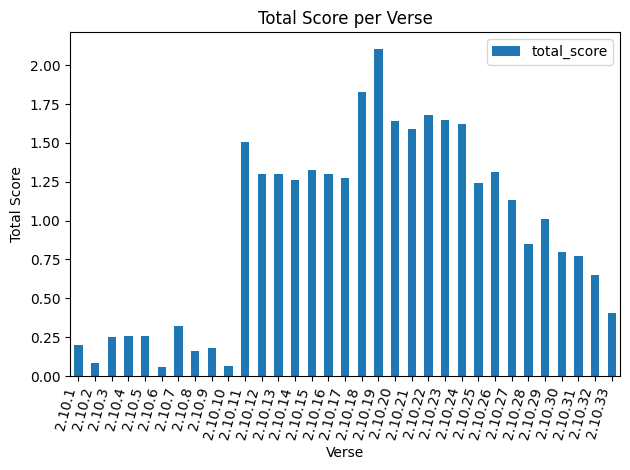

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_scores.plot(x='Verse', y='total_score', kind='bar')
plt.title('Total Score per Verse')
plt.xlabel('Verse')
plt.ylabel('Total Score')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

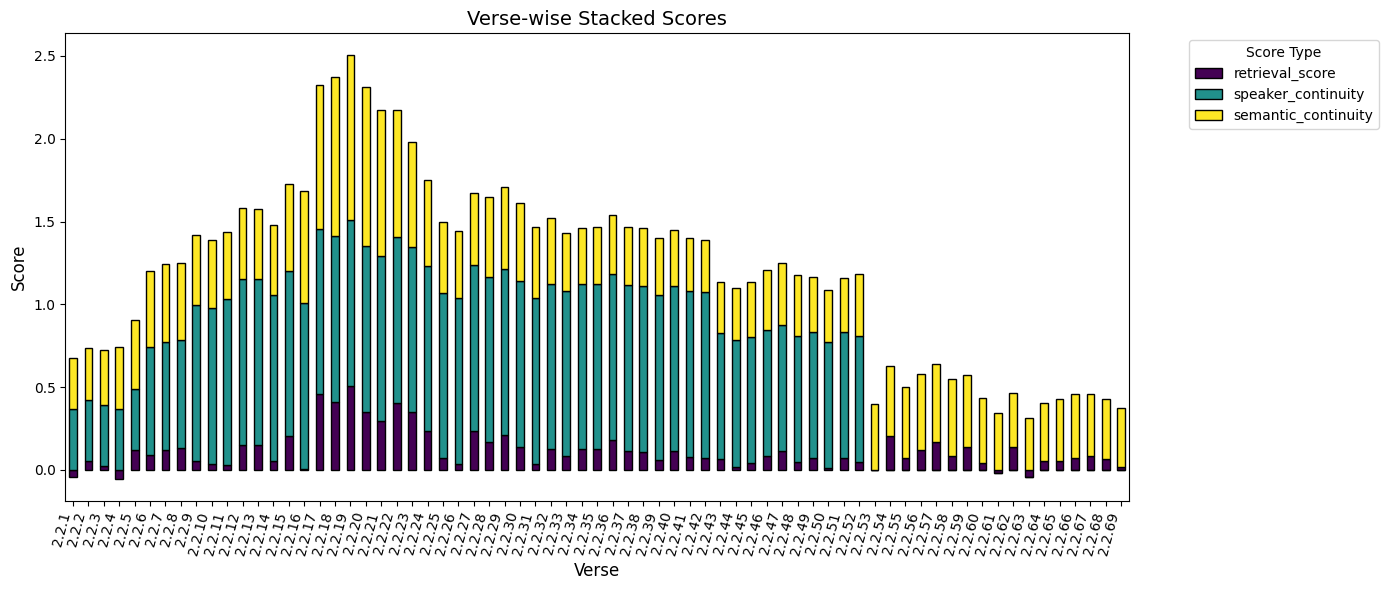

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is df
score_cols = ["retrieval_score"	,"speaker_continuity",	"semantic_continuity"]

# Set figure size for readability
plt.figure(figsize=(12, 6))

# Plot stacked bar chart
df_scores.plot(
    x="Verse",
    y=score_cols,
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    colormap="viridis",   # you can try 'plasma', 'coolwarm', etc.
    edgecolor="black"
)

# Formatting
plt.title("Verse-wise Stacked Scores", fontsize=14)
plt.xlabel("Verse", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.legend(title="Score Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


In [ ]:
!pip install kneed

In [ ]:
## Extact verse chunks
from sklearn.cluster import KMeans
import numpy as np

def extract(query, target_verse):

  df_scores = compute_total_continuity(
      query=query,
      target_verse=target_verse,
      vp_text=vp_text,
      speakers_dict=speakers,
      alpha=0.2,
      window=2,
      group_size=3,
      weight_speaker=1.5
  )


  scores = df_scores['total_score'].values.reshape(-1, 1)
  labels = KMeans(
      n_clusters=2,
      init='k-means++',
      n_init=50,
      max_iter=500,
      random_state=42
  ).fit_predict(scores)
  df_scores['selected'] = labels == labels[np.argmax(scores)]

  df_selected = df_scores[df_scores["selected"]].copy()
  df_selected.reset_index(drop=True, inplace=True)

  df_selected = sort_df(df_selected)

  start_verse = df_selected["verse"].iloc[0]
  end_verse = df_selected["verse"].iloc[-1]

  return f"{start_verse} - {end_verse}"



In [ ]:
target_verses = {
    0: "2.1.15",
    1: "2.2.19",
    2: "2.3.30",
    3: "2.4.17",
    4: "2.4.8",
    5: "2.8.1",
    6: "2.9.6",
    7: "2.10.11",
    8: "2.10.19"
}

ext_2 = []

for i, v in target_verses.items():
  print(v, queries[i])
  ext_2.append(extract(queries[i], v))

2.1.15 What did the citizens of Hastinapura tell to the pandavas when they were leaving for their exile
(40, 3) (40, 2) (40, 2)
2.2.19 What is the relation between mental and physical ailments
(69, 3) (69, 2) (69, 2)
2.3.30 What is the Surya Stuti recited by Yudhishthira
(62, 3) (62, 2) (62, 2)
2.4.17 What does Dhritarashtra say to Vidura while banishing him
(21, 3) (21, 2) (21, 2)
2.4.8 What advice does Vidura give Dhritarashtra after the departure of the Pandavas
(21, 3) (21, 2) (21, 2)
2.8.1 What advice does Vyasa give Dhritarashtra on the plan of the kauravas
(10, 3) (10, 2) (10, 2)
2.9.6 What is the story of Indra and Surabhi
(20, 3) (20, 2) (20, 2)
2.10.11 What did Sage Maitreya tell Dhritarasthra
(33, 3) (33, 2) (33, 2)
2.10.19 What did Sage Maitreya tell Duryodhana
(33, 3) (33, 2) (33, 2)


In [ ]:
verses_ext_2 = []
for r in ext_2:
    start, end = r.split('-')
    start, end = start.strip(), end.strip()

    s_parts = start.split('.')
    e_parts = end.split('.')

    prefix = '.'.join(s_parts[:-1])
    s_num, e_num = int(s_parts[-1]), int(e_parts[-1])

    verses_ext_2.append([f"{prefix}.{i}" for i in range(s_num, e_num + 1)])

In [ ]:
for e in ext_2:
  print(e)

2.1.8 - 2.1.17
2.2.6 - 2.2.52
2.3.20 - 2.3.62
2.4.17 - 2.4.21
2.4.2 - 2.4.20
2.8.1 - 2.8.1
2.9.4 - 2.9.7
2.10.7 - 2.10.29
2.10.11 - 2.10.29


In [ ]:
for i, (v_ext, v_gt) in enumerate(zip(verses_ext_2, verses_gt)):
  tp = len(set(v_ext) & set(v_gt))
  total = len(v_gt)

  fp = len(set(v_ext) - set(v_gt))
  total_ext = len(v_ext)

  common = set(v_ext) & set(v_gt)
  if total_ext == 0:
    completeness = 0
    purity = 0
  else:
    completeness = tp/total
    purity = 1 - fp/total_ext
  print(f"Q.{i+1} | {common} | {v_gt[0]} - {v_gt[-1]} | {completeness} | {purity}")

Q.1 | {'2.1.16', '2.1.14', '2.1.17', '2.1.13', '2.1.12', '2.1.15'} | 2.1.12 - 2.1.27 | 0.375 | 0.6
Q.2 | {'2.2.18', '2.2.21', '2.2.17', '2.2.20', '2.2.19', '2.2.22', '2.2.23'} | 2.2.17 - 2.2.23 | 1.0 | 0.14893617021276595
Q.3 | {'2.3.32', '2.3.25', '2.3.36', '2.3.43', '2.3.38', '2.3.30', '2.3.40', '2.3.37', '2.3.33', '2.3.46', '2.3.35', '2.3.29', '2.3.41', '2.3.27', '2.3.47', '2.3.23', '2.3.26', '2.3.22', '2.3.45', '2.3.24', '2.3.31', '2.3.42', '2.3.28', '2.3.39', '2.3.34', '2.3.44'} | 2.3.22 - 2.3.47 | 1.0 | 0.6046511627906976
Q.4 | {'2.4.19', '2.4.17', '2.4.20', '2.4.18'} | 2.4.17 - 2.4.20 | 1.0 | 0.8
Q.5 | {'2.4.10', '2.4.15', '2.4.6', '2.4.11', '2.4.12', '2.4.8', '2.4.16', '2.4.7', '2.4.14', '2.4.9', '2.4.13'} | 2.4.6 - 2.4.16 | 1.0 | 0.5789473684210527
Q.6 | {'2.8.1'} | 2.8.1 - 2.8.10 | 0.1 | 1.0
Q.7 | {'2.9.6', '2.9.7', '2.9.5'} | 2.9.5 - 2.9.16 | 0.25 | 0.75
Q.8 | {'2.10.15', '2.10.16', '2.10.12', '2.10.14', '2.10.13', '2.10.17', '2.10.11'} | 2.10.11 - 2.10.17 | 1.0 | 0.30434782